<a href="https://colab.research.google.com/github/Saritakumari540/Depression-detection-by-audio/blob/main/DepressionDetectionByAudio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import dependencies

In [131]:
!wget https://zenodo.org/records/1188976/files/Audio_Speech_Actors_01-24.zip?download=1

--2024-11-09 23:56:30--  https://zenodo.org/records/1188976/files/Audio_Speech_Actors_01-24.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.184.103.159, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 208468073 (199M) [application/octet-stream]
Saving to: ‘Audio_Speech_Actors_01-24.zip?download=1.2’

Audio_Speech_Actors 100%[===================>] 198.81M  30.0MB/s    in 7.8s    

2024-11-09 23:56:38 (25.6 MB/s) - ‘Audio_Speech_Actors_01-24.zip?download=1.2’ saved [208468073/208468073]



In [132]:
!mkdir -p data/input
!mkdir -p data/working/Depression
!mkdir -p data/working/NonDepression

In [ ]:
!unzip Audio_Speech_Actors_01-24.zip?download=1 -d ./data/input

In [134]:
!pip install tensorflow-io

In [135]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import shutil

# Data Preparation

In [136]:
base_src_directory = "data/input"
destination_directories = {
    'Depression': 'data/working/Depression/',
    'NonDepression': 'data/working/NonDepression/'
}

def copy_files_with_specific_number():
    count = 0
    for i in range(1, 25):
        actor_folder = f"Actor_{str(i).zfill(2)}"
        src_directory = os.path.join(base_src_directory, actor_folder)

        for category, base_destination_directory in destination_directories.items():
            destination_directory = os.path.join(base_destination_directory)

            if not os.path.exists(destination_directory):
                os.makedirs(destination_directory)

            for filename in os.listdir(src_directory):
                if '-' in filename:
                    parts = filename.split('-')
                    if len(parts) >= 3:
                        number = parts[2][:2]
                        if (category == 'Depression' and number in ['04', '05', '06', '07']) or \
                           (category == 'NonDepression' and number in ['01', '02', '03', '08']):
                            source_path = os.path.join(src_directory, filename)
                            destination_path = os.path.join(destination_directory, filename)
                            shutil.copy(source_path, destination_path)
                            count += 1
    print(f"Total files moved: {count}")

copy_files_with_specific_number()

Total files moved: 1440


# Data Loading

In [137]:
def compare_header_and_size(wav_filename):
    with wave.open(wav_filename, 'r') as fin:
        header_fsize = (fin.getnframes() * fin.getnchannels() * fin.getsampwidth()) + 44
    file_fsize = os.path.getsize(wav_filename)
    return header_fsize != file_fsize


In [138]:
DEPRESSION_FILE = os.path.join('data', 'working', 'Depression', '03-01-05-01-01-01-02.wav')
NOT_DEPRESSION_FILE = os.path.join('data', 'working', 'NonDepression', '03-01-02-01-02-02-19.wav')

In [139]:
import tensorflow as tf
import tensorflow_io as tfio

def load_wav_16k_mono(filename):
    try:
        file_contents = tf.io.read_file(filename)
        wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
        wav = tf.squeeze(wav, axis=-1)
        sample_rate = tf.cast(sample_rate, dtype=tf.int64)
        wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
        return wav
    except tf.errors.InvalidArgumentError as e:
        # Print warning and skip this file if it’s corrupt or invalid
        print(f"Warning: Skipping file {filename} due to error: {e}")
        return None

In [140]:
wave = load_wav_16k_mono(DEPRESSION_FILE)
nwave = load_wav_16k_mono(NOT_DEPRESSION_FILE)

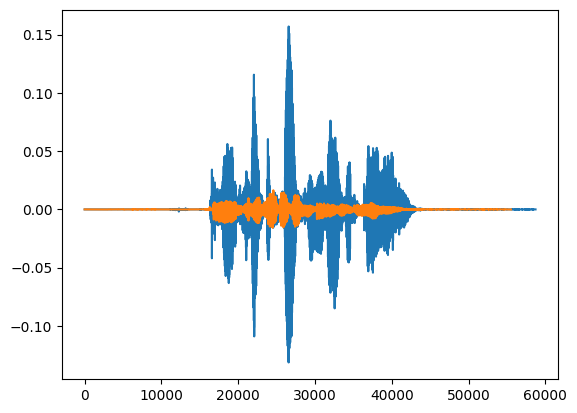

In [141]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# Average length of Audio

In [ ]:
lengths = []
for file in os.listdir(os.path.join('data', 'working', 'Depression')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'working', 'Depression', file))
    if tensor_wave is not None:
        lengths.append(len(tensor_wave))
    else:
        print(f"Skipping file {file} due to loading error.")
        os.remove(f"data/working/Depression/{file}")
for file in os.listdir(os.path.join('data', 'working', 'NonDepression')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'working', 'NonDepression', file))
    if tensor_wave is not None:
        lengths.append(len(tensor_wave))
    else:
        print(f"Skipping file {file} due to loading error.")
        os.remove(f"data/working/NonDepression/{file}")

In [143]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=59366>

In [144]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=46980>

In [145]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=84351>

# Tensorflow dataset pipeline

In [170]:
POS = os.path.join('data', 'working', 'Depression')
NEG = os.path.join('data', 'working', 'NonDepression')

In [171]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [172]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [178]:
data.as_numpy_iterator().next()

(b'data/working/Depression/03-01-04-01-01-02-21.wav', 1.0)

# Preprocessing

In [179]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [180]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [181]:
spectrogram, label = preprocess(filepath, label)

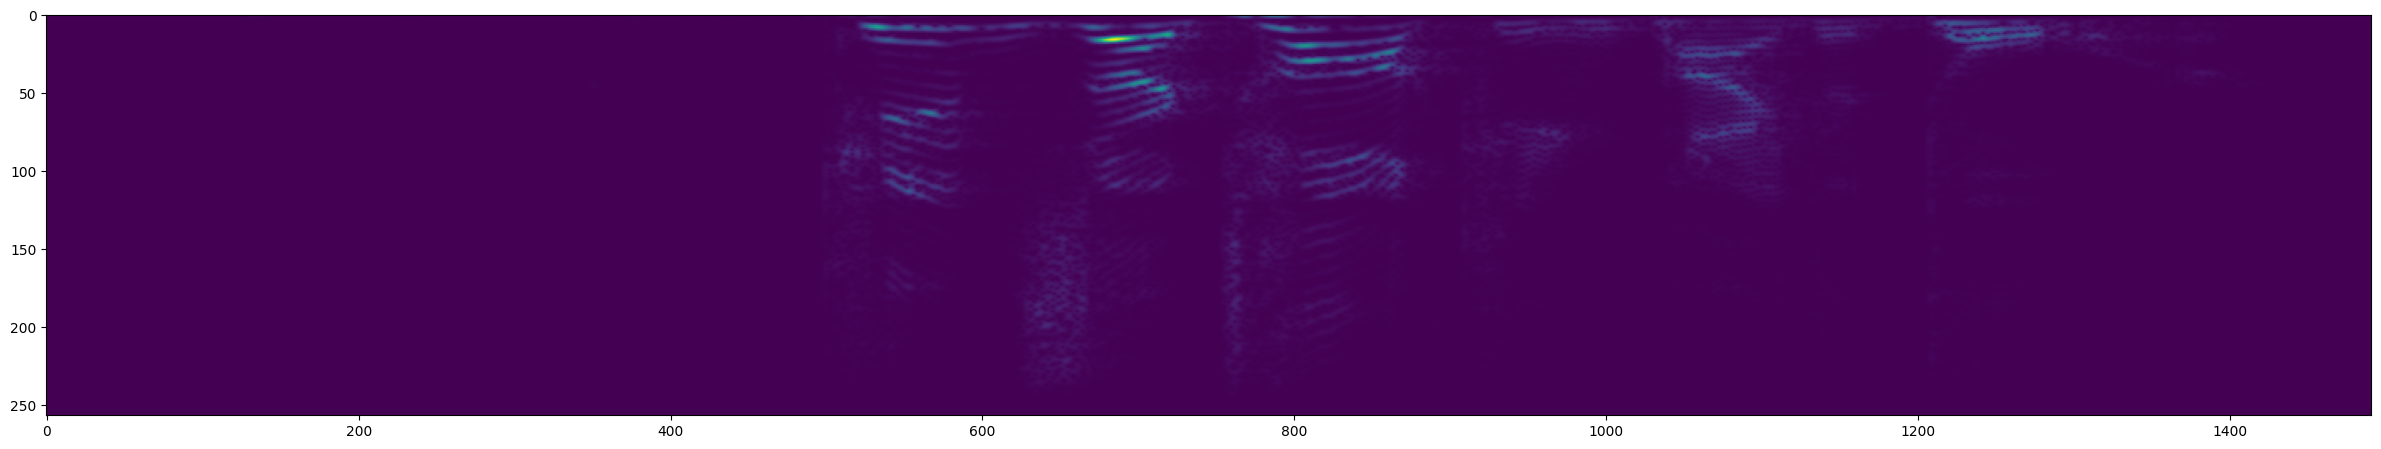

In [182]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# Train test partitioning

In [183]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)


In [184]:
train = data.take(36)
test = data.skip(36).take(15)

In [185]:
samples, labels = train.as_numpy_iterator().next()
samples.shape

(16, 1491, 257, 1)